```
         Copyright Rein Halbersma 2020.
Distributed under the Boost Software License, Version 1.0.
   (See accompanying file LICENSE_1_0.txt or copy at
         http://www.boost.org/LICENSE_1_0.txt)
```

# Monte Carlo simulation for the game of Blackjack

In [1]:
import gym
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from doctrina.algorithms import dp, mc
from doctrina.spaces import shape, size, state_table
import gym_blackjack_v1 as bj

env = gym.make('Blackjack-v1', model_based=True)
env.seed(47110815)

[47110815]

## The payout

In [2]:
pd.DataFrame(
    env.payout,
    index=bj.count_labels,  # player count
    columns=bj.count_labels # dealer count
)

,BUST,<17,17,18,19,20,21,BJ
BUST,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
<17,1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
17,1.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0
18,1.0,1.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0
19,1.0,1.0,1.0,1.0,0.0,-1.0,-1.0,-1.0
20,1.0,1.0,1.0,1.0,1.0,0.0,-1.0,-1.0
21,1.0,1.0,1.0,1.0,1.0,1.0,0.0,-1.0
BJ,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


## Example 5.1: Blackjack

100%|██████████| 500000/500000 [00:18<00:00, 26633.62it/s]


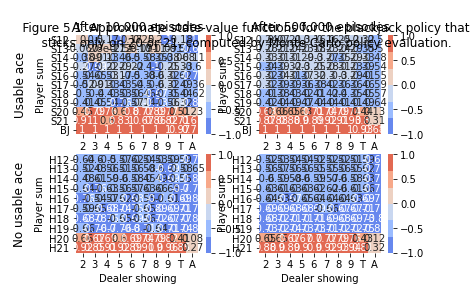

In [3]:
# Consider the policy that sticks if the player’s sum is 20 or 21, and otherwise hits.
stand_on_20 = np.full(shape(env.observation_space), bj.Action.HIT)
stand_on_20[bj.Hand.H20:(bj.Hand.H21 + 1), :] = bj.Action.STAND
stand_on_20[bj.Hand.S20:(bj.Hand.BJ  + 1), :] = bj.Action.STAND

# In any event, after 500,000 games the value function is very well approximated.
runs = [ 10_000, 500_000 ]
Vs, Ns = zip(*[ 
    mc.predict_ev(env, episodes, stand_on_20) 
    for episodes in runs 
])

options = {
    'vmin': min(env.reward_range), 
    'vmax': max(env.reward_range), 
    'cmap': sns.color_palette('coolwarm'), 
    'center': 0.,
    'annot': True, 
    'xticklabels': bj.card_labels
}

hands = [
    np.arange(bj.Hand.S12, bj.Hand.BJ  + 1),
    np.arange(bj.Hand.H12, bj.Hand.H21 + 1)
]

yticklabels = [ 
    np.array(bj.hand_labels)[hands[no_usable_ace]] 
    for no_usable_ace in range(2)
]

axopts = {
    'xlabel': 'Dealer showing',
    'ylabel': 'Player sum'
}

fig, axes = plt.subplots(nrows=2, ncols=len(runs))
fig.suptitle(
    """
    Figure 5.1: Approximate state-value functions for the blackjack policy that
    sticks only on 20 or 21, computed by Monte Carlo policy evaluation.
    """
)
rows = [ 'Usable ace', 'No usable ace']
cols = [ f'After {episodes:,} episodes' for episodes in runs ]

# https://stackoverflow.com/questions/25812255/row-and-column-headers-in-matplotlibs-subplots
pad = 5 # in points

for ax, row in zip(axes[:,0], rows):
    ax.annotate(
        row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
        xycoords=ax.yaxis.label, textcoords='offset points',
        size='large', ha='right', va='center', rotation=90
    )

for ax, col in zip(axes[0,:], cols):
    ax.annotate(
        col, xy=(0.5, 1), xytext=(0, pad),
        xycoords='axes fraction', textcoords='offset points',
        size='large', ha='center', va='baseline'
    )

for i, h in enumerate(hands):
    for r, _ in enumerate(runs):
        sns.heatmap(Vs[r][h, :], yticklabels=yticklabels[i], ax=axes[i, r], **options).set(**axopts)
plt.show()

In [4]:
pd.DataFrame(
    Vs[1],
    index=bj.hand_labels, 
    columns=bj.card_labels
).round(4)

,2,3,4,5,6,7,8,9,T,A
H4,-0.5021,-0.4264,-0.5592,-0.5903,-0.4350,-0.3445,-0.3857,-0.4323,-0.5694,-0.5801
H5,-0.4120,-0.4817,-0.4703,-0.5194,-0.5753,-0.4886,-0.5043,-0.3846,-0.5354,-0.6861
H6,-0.5014,-0.4736,-0.5014,-0.4747,-0.4962,-0.5007,-0.4817,-0.5043,-0.5637,-0.7086
H7,-0.5556,-0.5352,-0.5254,-0.5301,-0.5131,-0.5080,-0.4891,-0.4909,-0.5652,-0.6691
H8,-0.5567,-0.5401,-0.5693,-0.5872,-0.5487,-0.5200,-0.5286,-0.5275,-0.5874,-0.7066
H9,-0.5170,-0.5704,-0.5246,-0.5328,-0.5190,-0.4751,-0.4993,-0.5009,-0.5775,-0.6548
H10,-0.1179,-0.1417,-0.0989,-0.1185,-0.1120,-0.0698,-0.0615,-0.0707,-0.2266,-0.3879
H11,-0.0652,-0.0817,-0.0680,-0.0654,-0.0514,-0.0445,-0.0624,-0.0500,-0.1443,-0.3598
H12,-0.5233,-0.5294,-0.5431,-0.5389,-0.5187,-0.5199,-0.5205,-0.5117,-0.5857,-0.6664
H13,-0.5553,-0.5716,-0.5585,-0.5577,-0.5539,-0.5491,-0.5557,-0.5528,-0.6154,-0.7140


In [5]:
# Although we have complete knowledge of the environment in the blackjack task, it
# would not be easy to apply DP methods to compute the value function.
policy = np.zeros(size(env.observation_space) + 1, dtype=int)
policy[:-1] = stand_on_20.reshape(size(env.observation_space))
V_dp, *_ = dp.V_policy_eval_deter_sync(env, policy, tol=1e-9)
pd.DataFrame(
    state_table(V_dp, env), 
    index=bj.hand_labels, 
    columns=bj.card_labels
).round(4)

,2,3,4,5,6,7,8,9,T,A
H4,-0.4783,-0.4762,-0.4741,-0.4723,-0.4656,-0.4518,-0.4483,-0.4521,-0.5195,-0.6331
H5,-0.4963,-0.4943,-0.4923,-0.4905,-0.4840,-0.4707,-0.4673,-0.4710,-0.5360,-0.6458
H6,-0.5144,-0.5125,-0.5105,-0.5088,-0.5026,-0.4897,-0.4865,-0.4900,-0.5527,-0.6585
H7,-0.5322,-0.5304,-0.5285,-0.5268,-0.5209,-0.5085,-0.5053,-0.5087,-0.5692,-0.6711
H8,-0.5539,-0.5521,-0.5503,-0.5488,-0.5431,-0.5314,-0.5285,-0.5316,-0.5887,-0.6862
H9,-0.5210,-0.5189,-0.5167,-0.5148,-0.5080,-0.4939,-0.4903,-0.4950,-0.5630,-0.6636
H10,-0.1314,-0.1271,-0.1227,-0.1188,-0.1048,-0.0760,-0.0685,-0.0797,-0.2170,-0.3908
H11,-0.0755,-0.0729,-0.0701,-0.0677,-0.0589,-0.0408,-0.0364,-0.0379,-0.1301,-0.3482
H12,-0.5449,-0.5431,-0.5413,-0.5397,-0.5339,-0.5220,-0.5190,-0.5222,-0.5805,-0.6799
H13,-0.5774,-0.5757,-0.5740,-0.5726,-0.5672,-0.5561,-0.5533,-0.5563,-0.6104,-0.7028


In [6]:
# In any event, after 500,000 games the value function is very well approximated.
pd.DataFrame(
    (Vs[1] - state_table(V_dp, env)) / state_table(V_dp, env), 
    index=bj.hand_labels, 
    columns=bj.card_labels
).style.format('{:,.2%}')

,2,3,4,5,6,7,8,9,T,A
H4,4.99%,-10.48%,17.94%,24.99%,-6.58%,-23.74%,-13.97%,-4.37%,9.62%,-8.38%
H5,-16.98%,-2.55%,-4.45%,5.89%,18.85%,3.80%,7.92%,-18.34%,-0.11%,6.24%
H6,-2.53%,-7.59%,-1.78%,-6.70%,-1.27%,2.24%,-0.99%,2.91%,1.98%,7.60%
H7,4.38%,0.91%,-0.59%,0.62%,-1.50%,-0.08%,-3.22%,-3.51%,-0.69%,-0.29%
H8,0.51%,-2.18%,3.44%,7.00%,1.02%,-2.15%,0.02%,-0.77%,-0.23%,2.96%
H9,-0.77%,9.92%,1.52%,3.49%,2.16%,-3.81%,1.85%,1.21%,2.58%,-1.31%
H10,-10.24%,11.47%,-19.40%,-0.29%,6.84%,-8.13%,-10.13%,-11.25%,4.42%,-0.74%
H11,-13.63%,12.05%,-3.01%,-3.40%,-12.74%,9.19%,71.28%,31.90%,10.88%,3.33%
H12,-3.96%,-2.53%,0.34%,-0.14%,-2.85%,-0.41%,0.29%,-2.00%,0.90%,-1.99%
H13,-3.82%,-0.72%,-2.71%,-2.60%,-2.34%,-1.26%,0.43%,-0.63%,0.81%,1.59%


## Example 5.3: Solving Blackjack

100%|██████████| 500000/500000 [00:21<00:00, 23525.28it/s]


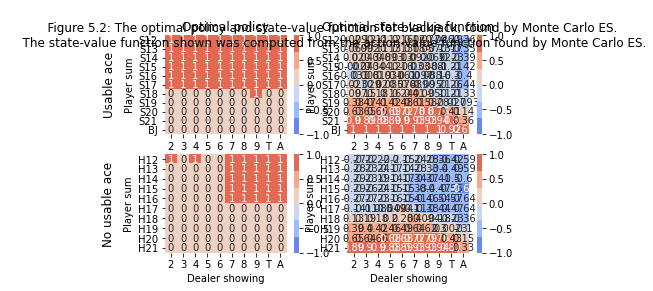

In [7]:
episodes = 500_000
policy0 = stand_on_20
policy, Q, N = mc.control_es(env, episodes, policy0)
assert (policy == Q.argmax(axis=2)).all()
policy = Q.argmax(axis=2)
V = Q.max(axis=2)

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.suptitle(
    """
    Figure 5.2: The optimal policy and state-value function for blackjack, found by Monte Carlo ES. 
    The state-value function shown was computed from the action-value function found by Monte Carlo ES.
    """
)
rows = [ 'Usable ace', 'No usable ace']
cols = [ 'Optimal policy', 'Optimal state-value function' ]

# https://stackoverflow.com/questions/25812255/row-and-column-headers-in-matplotlibs-subplots
pad = 5 # in points

for ax, row in zip(axes[:,0], rows):
    ax.annotate(
        row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
        xycoords=ax.yaxis.label, textcoords='offset points',
        size='large', ha='right', va='center', rotation=90
    )

for ax, col in zip(axes[0,:], cols):
    ax.annotate(
        col, xy=(0.5, 1), xytext=(0, pad),
        xycoords='axes fraction', textcoords='offset points',
        size='large', ha='center', va='baseline'
    )

for i, h in enumerate(hands):
    sns.heatmap(policy[h, :], yticklabels=yticklabels[i], ax=axes[i, 0], **options).set(**axopts)
    sns.heatmap(     V[h, :], yticklabels=yticklabels[i], ax=axes[i, 1], **options).set(**axopts)
plt.show()

In [8]:
pd.DataFrame(
    V, 
    index=bj.hand_labels, 
    columns=bj.card_labels
).round(4)

,2,3,4,5,6,7,8,9,T,A
H4,-0.1524,-0.0916,-0.0856,-0.0047,-0.0111,-0.1655,-0.1825,-0.2522,-0.3561,-0.4393
H5,-0.1478,-0.0738,-0.0383,-0.0499,-0.0012,-0.1286,-0.2229,-0.2954,-0.2854,-0.5636
H6,-0.1139,-0.0671,-0.1086,-0.0205,-0.0030,-0.1211,-0.2261,-0.3068,-0.4022,-0.5172
H7,-0.1597,-0.0841,-0.0744,-0.0473,0.0390,-0.0711,-0.1739,-0.2356,-0.3503,-0.4733
H8,0.0455,0.0000,0.0504,0.1094,0.0763,0.0680,-0.0526,-0.2530,-0.2788,-0.4340
H9,0.1450,0.1031,0.0934,0.1527,0.2410,0.1967,0.1334,-0.0406,-0.2438,-0.3590
H10,0.1522,0.2020,0.2382,0.2435,0.2612,0.2630,0.1493,0.0844,-0.0475,-0.2806
H11,0.2365,0.2383,0.2715,0.3110,0.3713,0.3189,0.2277,0.1213,0.0661,-0.1965
H12,-0.2684,-0.2222,-0.2167,-0.1976,-0.1495,-0.2437,-0.2753,-0.3649,-0.4219,-0.5856
H13,-0.2827,-0.2304,-0.2405,-0.1667,-0.1358,-0.2768,-0.3336,-0.3976,-0.4859,-0.5930


In [9]:
pd.DataFrame(
    policy, 
    index=bj.hand_labels, 
    columns=bj.card_labels
).applymap(lambda a: bj.action_labels[a]).replace({'S': ' '})

,2,3,4,5,6,7,8,9,T,A
H4,H,H,H,H,H,H,H,H,H,H
H5,H,H,H,H,H,H,H,H,H,H
H6,H,H,H,H,H,H,H,H,H,H
H7,H,H,H,H,H,H,H,H,H,H
H8,H,H,H,H,H,H,H,H,H,H
H9,H,H,H,H,H,H,H,H,H,H
H10,H,H,H,H,H,H,H,H,H,H
H11,H,H,H,H,H,H,H,H,H,H
H12,H,,H,,,H,H,H,H,H
H13,,,,,,H,H,H,H,H


In [10]:
V, policy, *_ = dp.V_value_iter(env)

In [11]:
pd.DataFrame(
    state_table(V, env), 
    index=bj.hand_labels, 
    columns=bj.card_labels
).round(4)

,2,3,4,5,6,7,8,9,T,A
H4,-0.1149,-0.0826,-0.0494,-0.0124,0.0111,-0.0883,-0.1593,-0.2407,-0.3439,-0.4829
H5,-0.1282,-0.0953,-0.0615,-0.0240,-0.0012,-0.1194,-0.1881,-0.2666,-0.3662,-0.5006
H6,-0.1408,-0.1073,-0.0729,-0.0349,-0.0130,-0.1519,-0.2172,-0.2926,-0.3887,-0.5183
H7,-0.1092,-0.0766,-0.0430,-0.0073,0.0292,-0.0688,-0.2106,-0.2854,-0.3714,-0.5224
H8,-0.0218,0.0080,0.0388,0.0708,0.1150,0.0822,-0.0599,-0.2102,-0.3071,-0.4441
H9,0.0744,0.1013,0.1290,0.1580,0.1960,0.1719,0.0984,-0.0522,-0.2181,-0.3532
H10,0.1825,0.2061,0.2305,0.2563,0.2878,0.2569,0.1980,0.1165,-0.0536,-0.2513
H11,0.2384,0.2603,0.2830,0.3073,0.3337,0.2921,0.2300,0.1583,0.0334,-0.2087
H12,-0.2534,-0.2337,-0.2111,-0.1672,-0.1537,-0.2128,-0.2716,-0.3400,-0.4287,-0.5504
H13,-0.2928,-0.2523,-0.2111,-0.1672,-0.1537,-0.2691,-0.3236,-0.3872,-0.4695,-0.5825


In [12]:
pd.DataFrame(
    state_table(policy, env), 
    index=bj.hand_labels, 
    columns=bj.card_labels
).applymap(lambda a: bj.action_labels[a]).replace({'S': ' '})

,2,3,4,5,6,7,8,9,T,A
H4,H,H,H,H,H,H,H,H,H,H
H5,H,H,H,H,H,H,H,H,H,H
H6,H,H,H,H,H,H,H,H,H,H
H7,H,H,H,H,H,H,H,H,H,H
H8,H,H,H,H,H,H,H,H,H,H
H9,H,H,H,H,H,H,H,H,H,H
H10,H,H,H,H,H,H,H,H,H,H
H11,H,H,H,H,H,H,H,H,H,H
H12,H,H,,,,H,H,H,H,H
H13,,,,,,H,H,H,H,H


## Example 5.4: Off-policy Estimation of a Blackjack State Value

In [13]:
# We evaluated the state in which the dealer is showing a deuce, 
# the sum of the player’s cards is 13, and the player has a usable ace 
# (that is, the player holds an ace and a deuce, or equivalently three aces).
start = (bj.Hand.S13, bj.Card._2)

# The target policy was to stick only on a sum of 20 or 21, as in Example 5.1.
target_policy = stand_on_20

# The value of this state under the target policy is approximately −0.27726 
# (this was determined by separately generating one-hundred million episodes 
# using the target policy and averaging their returns).
episodes = 1_000_000
V, _ = mc.predict_ev(env, episodes, target_policy, start)
V[start]

100%|██████████| 1000000/1000000 [00:37<00:00, 26345.06it/s]


-0.27729100000001067

In [14]:
# Model-based policy evaluation using dynamic programming
state_table(V_dp, env)[start]

-0.27720419182542605

## References
[Reinforcement Learning, an Introduction, second edition] (http://incompleteideas.net/book/RLbook2020.pdf), Richard S. Sutton and Andrew G. Barto (2018).